Published on January 23, 2023 by Marília Prata, mpwolke.

In [3]:
# import libraries
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import classification_report

In [4]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Set the target size for image resizing
IMG_SIZE = (224, 224)  # You can change this as needed

# Root dataset folder
DATASET_DIR = '/kaggle/input/normal-vs-military-vehicles/dataset'

# Categories (subfolder names = class labels)
CATEGORIES = ['millitary', 'other']

# Function to load images and labels from a given split (train/test/val)
def load_images(split):
    images = []
    labels = []
    for label in CATEGORIES:
        folder_path = os.path.join(DATASET_DIR, split, label)
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpeg'):
                img_path = os.path.join(folder_path, filename)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load data for each split
X_train, y_train = load_images('train')
X_test, y_test = load_images('test')
X_val, y_val = load_images('validation')

# Normalize images to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Encode labels to integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

# Display shapes as confirmation
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)

X_train: (11170, 224, 224, 3) y_train: (11170,)
X_test: (2792, 224, 224, 3) y_test: (2792,)
X_val: (3491, 224, 224, 3) y_val: (3491,)


In [5]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input

# Input shape for the network (adjust according to your data)
input_shape = (224, 224, 3)

# Create an input layer
input_tensor = Input(shape=input_shape)

# Create MobileNetV1 model
mobilenet_model = MobileNet(input_shape=input_shape, include_top=False, weights=None, classes=2)

# Summary of the model architecture
#mobilenet_model.summary()
flatten_layer = Flatten()
dense_layer_1 = Dense(256, activation='relu')
prediction_layer = Dense(2, activation='sigmoid')

In [6]:
from tensorflow.keras import models
model = models.Sequential([
    mobilenet_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

In [7]:
# tell the model what cost and optimization method to use
model.compile(
optimizer = 'adam',
#loss = tf.keras.losses.SparseCategoricalCrossentropy(),
loss = tf.keras.losses.BinaryCrossentropy(),
metrics = ['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               12845312  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 16,074,690
Trainable params: 16,052,802
Non-trainable params: 21,888
_________________________________________________________________


In [9]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [10]:
y_test.shape

(2792, 2)

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
350/350 [==============================] - 65s 157ms/step - loss: 0.8908 - accuracy: 0.7536 - val_loss: 0.7603 - val_accuracy: 0.4588
Epoch 2/50
350/350 [==============================] - 53s 151ms/step - loss: 0.4022 - accuracy: 0.8256 - val_loss: 0.7442 - val_accuracy: 0.6325
Epoch 3/50
350/350 [==============================] - 53s 151ms/step - loss: 0.3347 - accuracy: 0.8564 - val_loss: 0.2981 - val_accuracy: 0.8721
Epoch 4/50
350/350 [==============================] - 53s 152ms/step - loss: 0.2843 - accuracy: 0.8817 - val_loss: 0.5893 - val_accuracy: 0.8284
Epoch 5/50
350/350 [==============================] - 53s 152ms/step - loss: 0.2685 - accuracy: 0.8880 - val_loss: 0.8130 - val_accuracy: 0.7400
Epoch 6/50
350/350 [==============================] - 53s 151ms/step - loss: 0.3108 - accuracy: 0.8717 - val_loss: 0.2926 - val_accuracy: 0.8689
Epoch 7/50
350/350 [==============================] - 53s 151ms/step - loss: 0.2457 - accuracy: 0.9010 - val_loss: 0.2919 - val_ac

In [12]:
y_train.shape

(11170, 2)

In [13]:
from tensorflow.keras.models import load_model

# Assuming you have already trained and compiled your model
# Save the model to a single file, including architecture, weights, and optimizer state
model.save("mob_militaryb_model.h5")

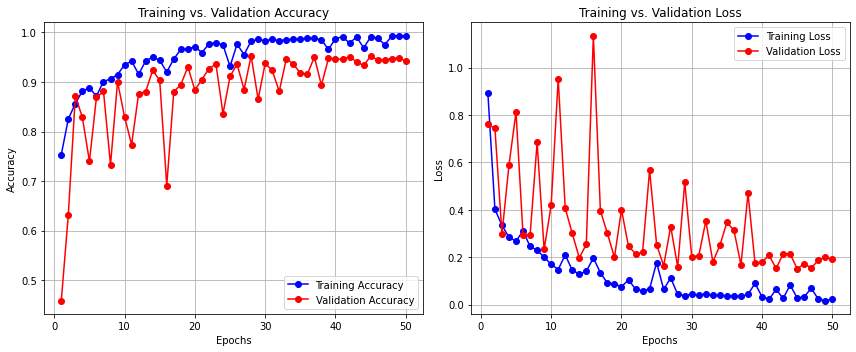

In [14]:
import matplotlib.pyplot as plt

# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Create the plot
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save the figure with 300 DPI resolution
plt.savefig('training_validation_metrics.png', dpi=300)

# Show the plot
plt.show()

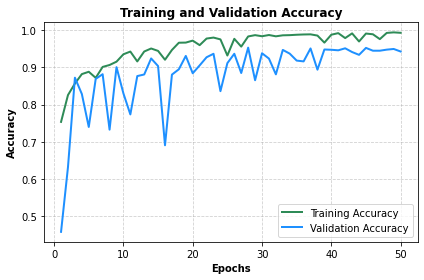

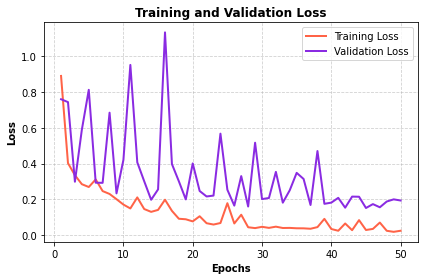

In [15]:
# Plot training history (accuracy and loss graphs)
def plot_training_history(history):
    # Retrieve accuracy and loss values from training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training & validation accuracy values
    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy', color='#2E8B57', linewidth=2)  # Green
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='#1E90FF', linewidth=2)  # Blue
    plt.title('Training and Validation Accuracy', fontweight='bold')
    plt.xlabel('Epochs', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid lines
    plt.tight_layout()
    
    # Save the accuracy plot to the output folder
    acc_plot_path = os.path.join('/kaggle/working/', 'accuracy_plot.png')
    plt.savefig(acc_plot_path, dpi=300)  # Save with high resolution
    plt.show()

    # Plot training & validation loss values
    plt.figure()
    plt.plot(epochs, loss, label='Training Loss', color='#FF6347', linewidth=2)  # Tomato red
    plt.plot(epochs, val_loss, label='Validation Loss', color='#8A2BE2', linewidth=2)  # BlueViolet
    plt.title('Training and Validation Loss', fontweight='bold')
    plt.xlabel('Epochs', fontweight='bold')
    plt.ylabel('Loss', fontweight='bold')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid lines
    plt.tight_layout()
    
    # Save the loss plot to the output folder
    loss_plot_path = os.path.join('/kaggle/working/', 'loss_plot.png')
    plt.savefig(loss_plot_path, dpi=300)  # Save with high resolution
    plt.show()

# Plot training history (accuracy and loss graphs)
plot_training_history(history)

Accuracy plot saved at: /kaggle/working/accuracy_plot.png


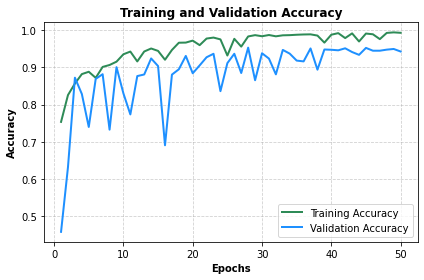

Loss plot saved at: /kaggle/working/loss_plot.png


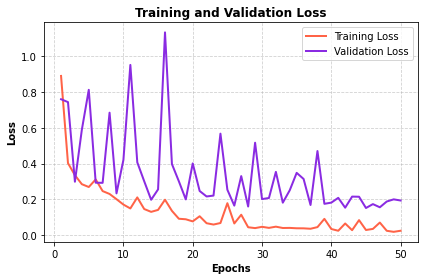

In [16]:
import os
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Retrieve accuracy and loss values from training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training & validation accuracy
    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy', color='#2E8B57', linewidth=2)
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='#1E90FF', linewidth=2)
    plt.title('Training and Validation Accuracy', fontweight='bold')
    plt.xlabel('Epochs', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Save accuracy plot at 300 DPI
    acc_plot_path = os.path.join('/kaggle/working/', 'accuracy_plot.png')
    plt.savefig(acc_plot_path, dpi=300)
    print(f"Accuracy plot saved at: {acc_plot_path}")
    plt.show()

    # Plot training & validation loss
    plt.figure()
    plt.plot(epochs, loss, label='Training Loss', color='#FF6347', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', color='#8A2BE2', linewidth=2)
    plt.title('Training and Validation Loss', fontweight='bold')
    plt.xlabel('Epochs', fontweight='bold')
    plt.ylabel('Loss', fontweight='bold')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Save loss plot at 300 DPI
    loss_plot_path = os.path.join('/kaggle/working/', 'loss_plot.png')
    plt.savefig(loss_plot_path, dpi=300)
    print(f"Loss plot saved at: {loss_plot_path}")
    plt.show()

# Usage
plot_training_history(history)